# Config

In [6]:
from datetime import datetime
import numpy as np
import pandas as pd

# Part 1 OIS Curve

## 1.1 Data

In [10]:
df = pd.read_excel("Bloomberg.xlsx", sheet_name='gbp ois results')

In [12]:
def reformat_ois_dataframe(df_raw):
    
    n = df_raw.shape[1] // 2  # 每两列是一组
    dfs = []

    for i in range(n):

        date_col = df_raw.columns[2 * i]
        rate_col = df_raw.columns[2 * i + 1]


        temp = df_raw[[date_col, rate_col]].copy()
        temp.columns = ['Date', 'Rate']

        temp['Date'] = pd.to_datetime(temp['Date'], errors='coerce')
        temp.dropna(subset=['Date'], inplace=True)

        temp.set_index('Date', inplace=True)
        temp.rename(columns={'Rate': rate_col}, inplace=True)       
        dfs.append(temp)

    df_final = pd.concat(dfs, axis=1, join='outer')
    df_final.sort_index(inplace=True)
    
    return df_final

ois_df = reformat_ois_dataframe(df)

In [14]:
ois_df.tail()

,BPSWS1Z Curncy,BPSWS2Z Curncy,BPSWSA Curncy,BPSWSB Curncy,BPSWSE Curncy,BPSWSF Curncy,BPSWSG Curncy,BPSWSH Curncy,BPSWSI Curncy,BPSWSJ Curncy,...,BPSWS8 Curncy,BPSWS9 Curncy,BPSWS10 Curncy,BPSWS12 Curncy,BPSWS15 Curncy,BPSWS20 Curncy,BPSWS25 Curncy,BPSWS30 Curncy,BPSWS40 Curncy,BPSWS50 Curncy
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-20,4.702,4.704,4.70900,4.70410,4.62260,4.59625,4.56487,4.53630,4.51151,4.48554,...,3.97335,3.9790,3.99100,4.0265,4.07392,4.10692,4.09602,4.05797,3.95250,3.83579
2024-11-21,4.702,4.704,4.70675,4.70400,4.61850,4.58900,4.55400,4.52600,4.49900,4.47290,...,3.94650,3.9545,3.96800,4.0060,4.05550,4.09050,4.08150,4.04400,3.94100,3.82500
2024-11-22,4.702,4.704,4.70470,4.69700,4.59500,4.56280,4.52550,4.49250,4.46300,4.43410,...,3.89800,3.9060,3.91850,3.9560,4.00500,4.03900,4.03096,3.99400,3.88900,3.77400
2024-11-25,4.702,4.704,4.70175,4.69862,4.59495,4.55800,4.52432,4.49405,4.46341,4.43810,...,3.87000,3.8740,3.88507,3.9205,3.96757,4.00150,3.99250,3.95507,3.85157,3.73650
2024-11-26,4.702,4.704,4.70134,4.69884,4.58976,4.55437,4.52000,4.48750,4.45950,4.43272,...,3.87631,3.8813,3.89286,3.9272,3.97346,4.00550,3.99470,3.95700,3.85200,3.73500


## 1.2 Build Curves

In [17]:
#from financepy.products.rates import IborDeposit, IborFRA, OIS
from financepy.products.rates import OIS
from financepy.utils import DayCountTypes, SwapTypes, FrequencyTypes
from financepy.products.rates import OISCurve
from financepy.utils.date import Date

ois_dict = {
    "BPSWS1Z Curncy": "1W",
    "BPSWS2Z Curncy": "2W",
    "BPSWSA Curncy":  "1M",
    "BPSWSB Curncy":  "2M",
    "BPSWSC Curncy":  "3M",
    "BPSWSD Curncy":  "4M",
    "BPSWSE Curncy":  "5M",
    "BPSWSF Curncy":  "6M",
    "BPSWSG Curncy":  "7M",
    "BPSWSH Curncy":  "8M",
    "BPSWSI Curncy":  "9M",
    "BPSWSJ Curncy":  "10M",
    "BPSWSK Curncy":  "11M",
    "BPSWS1 Curncy":  "1Y",
    "BPSWS1F Curncy": "18M",
    "BPSWS2 Curncy":  "2Y",
    "BPSWS3 Curncy":  "3Y",
    "BPSWS4 Curncy":  "4Y",
    "BPSWS5 Curncy":  "5Y",
    "BPSWS6 Curncy":  "6Y",
    "BPSWS7 Curncy":  "7Y",
    "BPSWS8 Curncy":  "8Y",
    "BPSWS9 Curncy":  "9Y",
    "BPSWS10 Curncy": "10Y",
    "BPSWS12 Curncy": "12Y",
    "BPSWS15 Curncy": "15Y",
    "BPSWS20 Curncy": "20Y",
    "BPSWS25 Curncy": "25Y",
    "BPSWS30 Curncy": "30Y",
    "BPSWS40 Curncy": "40Y",
    "BPSWS50 Curncy": "50Y"
}

def build_ois_curves(df):

    ois_curves = {}
    for date_str, row in df.iterrows():
       
        dt = pd.to_datetime(date_str)
        value_dt = Date(int(dt.day), int(dt.month), int(dt.year))
        ois_swaps = []

        for ticker, rate in row.items():
            tenor = ois_dict.get(ticker)
            if tenor is None or pd.isna(rate):
                continue  

            rate_decimal = rate / 100  
            inst = OIS(
                effective_dt=value_dt,
                term_dt_or_tenor=tenor,
                fixed_leg_type=SwapTypes.PAY,
                fixed_cpn=rate_decimal,
                fixed_freq_type=FrequencyTypes.QUARTERLY,
                fixed_dc_type=DayCountTypes.ACT_365F
            )
            ois_swaps.append(inst)
        
        ois_curve = OISCurve(
                    value_dt=value_dt,
                    ois_deposits=[],
                    ois_fras=[],
                    ois_swaps=ois_swaps, 
                )
        ois_curves[value_dt] = ois_curve

    return ois_curves


####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [18]:
ois_curves = build_ois_curves(ois_df)

# Part 2 Z-spread

## 2.1 Data

In [22]:
df2 = pd.read_excel("Gilts.xlsx", sheet_name='STATIC')
df3 = pd.read_excel("Gilts.xlsx", sheet_name='HIST_PRICE')

In [23]:
df2.head()

,instrument_id,bond_type_id,ticker,description,maturity_date,coupon,first_coupon_date,first_settlement_date
0,GB00B0V3WX43,GILT,UKT,UKT 4 07/09/16,2016-09-07,0.0400,2006-09-07,2006-03-02
1,GB00B3Z3K594,GILT,UKT,UKT 1.75 22/01/17,2017-01-22,0.0175,2012-01-22,2011-08-19
2,GB0008931148,GILT,UKT,UKT 8.75 25/08/17,2017-08-25,0.0875,1992-08-25,1992-04-30
3,GB00B7F9S958,GILT,UKT,UKT 1 07/09/17,2017-09-07,0.0100,2012-09-07,2012-03-08
4,GB00B1VWPC84,GILT,UKT,UKT 5 07/03/18,2018-03-07,0.0500,2007-09-07,2007-05-25


In [24]:
df3 = df3.set_index('eod_date').iloc[308:1023]
df3.head()

,GB0002404191,GB0004893086,GB0030880693,GB0032452392,GB00B00NY175,GB00B06YGN05,GB00B128DP45,GB00B16NNR78,GB00B1VWPJ53,GB00B24FF097,...,GB00BQC4R999,GB00BQC82B83,GB00BQC82C90,GB00BQC82D08,GB00BSQNRC93,GB00BSQNRD01,GB00BTHH2R79,GB00BYYMZX75,GB00BYZW3G56,GB00BZB26Y51
eod_date,,,,,,,,,,,,,,,,,,,,,
2022-01-27,1.32385,1.29010,1.12229,1.37410,1.51078,1.79839,1.59385,1.18070,1.55943,1.30151,...,NaN,NaN,NaN,NaN,NaN,NaN,1.03632,1.44296,1.02261,1.05036
2022-01-28,1.32289,1.28829,1.12183,1.37142,1.50852,1.79315,1.58915,1.18017,1.55563,1.29995,...,NaN,NaN,NaN,NaN,NaN,NaN,1.03606,1.43744,1.02242,1.04831
2022-01-31,1.31774,1.28109,1.11937,1.35949,1.49290,1.75863,1.56622,1.17592,1.53743,1.29365,...,NaN,NaN,NaN,NaN,NaN,NaN,1.03343,1.39985,1.01932,1.03727
2022-02-01,1.31695,1.28101,1.11886,1.36140,1.49566,1.76516,1.57080,1.17523,1.54073,1.29356,...,NaN,NaN,NaN,NaN,NaN,NaN,1.03294,1.40681,1.01892,1.03910
2022-02-02,1.32095,1.28700,1.12007,1.37182,1.50886,1.79733,1.59328,1.17789,1.55849,1.29875,...,NaN,NaN,NaN,NaN,NaN,NaN,1.03439,1.44202,1.02069,1.04899


## 2.2 Construct Bond Dict

In [26]:
from financepy.products.bonds import Bond

bond_dict = {}
for idx, row in df2.iterrows():
    isin = row["instrument_id"]  # ISIN, e.g. "GB00B0V3WX43"
    coupon_float = float(row["coupon"])  # e.g. 0.04 (4%)
    
    iss = pd.to_datetime(row["first_settlement_date"])
    issue_dt = Date(int(iss.day), int(iss.month), int(iss.year))
    
    
    mat_dt = pd.to_datetime(row["maturity_date"])
    maturity_dt = Date(mat_dt.day, mat_dt.month, mat_dt.year)
    
    bond_obj = Bond(issue_dt = issue_dt,
                    maturity_dt = maturity_dt,
                    coupon = coupon_float,
                    freq_type = FrequencyTypes.SEMI_ANNUAL,
                    dc_type = DayCountTypes.ACT_ACT_ICMA,
                   )
    bond_dict[isin] = bond_obj

## 2.3 Build Z-spread

In [33]:
zspread_dict = {}

for ticker in df3.columns:
    bond = bond_dict[ticker]
    if bond is None:
        zspread_dict[ticker] = []
        continue

    z_list = []

    for date, price in df3[ticker].items():
        if np.isnan(price):
            z_list.append(None)
            continue
            
        dt = pd.to_datetime(date)
        value_dt = Date(int(dt.day), int(dt.month), int(dt.year))
     
        ois_curve = ois_curves.get(value_dt)
        if ois_curve is None:
            z_list.append(None)
            continue

        z = bond.z_spread(value_dt, price, ois_curve)
        z_list.append(z)
    
    zspread_dict[ticker] = z_list

In [34]:
zspread_df = pd.DataFrame(zspread_dict, index=df3.index)
zspread_df.head()

,GB0002404191,GB0004893086,GB0030880693,GB0032452392,GB00B00NY175,GB00B06YGN05,GB00B128DP45,GB00B16NNR78,GB00B1VWPJ53,GB00B24FF097,...,GB00BQC4R999,GB00BQC82B83,GB00BQC82C90,GB00BQC82D08,GB00BSQNRC93,GB00BSQNRD01,GB00BTHH2R79,GB00BYYMZX75,GB00BYZW3G56,GB00BZB26Y51
eod_date,,,,,,,,,,,,,,,,,,,,,
2022-01-27,2.095505,1.783091,2.174929,1.723006,1.737730,1.466969,1.579780,1.870976,1.655027,1.883189,...,NaN,NaN,NaN,NaN,NaN,None,1.595825,1.234392,1.330734,1.162297
2022-01-28,2.093079,1.782426,2.178366,1.726578,1.737281,1.468407,1.581077,1.869131,1.655685,1.882017,...,NaN,NaN,NaN,NaN,NaN,None,1.597061,1.236480,1.330430,1.164252
2022-01-31,2.088031,1.782180,2.190215,1.740710,1.742001,1.482832,1.590619,1.866243,1.662235,1.880173,...,NaN,NaN,NaN,NaN,NaN,None,1.602088,1.256839,1.331119,1.174397
2022-02-01,2.085991,1.780639,2.194370,1.741567,1.738743,1.478541,1.586763,1.864979,1.658916,1.878349,...,NaN,NaN,NaN,NaN,NaN,None,1.603836,1.251133,1.331237,1.173661
2022-02-02,2.080579,1.774652,2.197442,1.736401,1.728953,1.461243,1.572449,1.861078,1.646878,1.872692,...,NaN,NaN,NaN,NaN,NaN,None,1.604679,1.227554,1.330371,1.166578


In [37]:
zspread_df.to_csv('zspread.csv', index=True)

# Part 3 NSS Curve

In [37]:
maturity_dict = {}
for idx, row in df2.iterrows():
    isin = row["instrument_id"]  # "GB00B0V3WX43" 等
    mat_dt = pd.to_datetime(row["maturity_date"])
    maturity_dict[isin] = mat_dt

In [39]:
def nss_func(t, beta0, beta1, beta2, beta3, tau1, tau2):
    t = np.array(t)
    term1 = (1 - np.exp(-t / tau1)) / (t / tau1)
    term2 = term1 - np.exp(-t / tau1)
    term3 = (1 - np.exp(-t / tau2)) / (t / tau2) - np.exp(-t / tau2)

    term1 = np.nan_to_num(term1, nan=1.0, posinf=0.0, neginf=0.0)
    term2 = np.nan_to_num(term2, nan=0.0, posinf=0.0, neginf=0.0)
    term3 = np.nan_to_num(term3, nan=0.0, posinf=0.0, neginf=0.0)

    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3

In [41]:
from scipy.optimize import curve_fit

nss_params_dict = {}

def get_nss_data_for_date(eod, zspread_df, maturity_dict):
    spread_series = zspread_df.loc[eod] 
    t_list = []
    z_list = []
    for isin, zval in spread_series.items():
        if pd.isna(zval):
            continue
        mat_dt = maturity_dict.get(isin)
        if mat_dt is None:
            continue
        t = (mat_dt - eod).days / 365.0
        if t > 0:
            t_list.append(t)
            z_list.append(zval)

    return np.array(t_list), np.array(z_list)

for eod, row in zspread_df.iterrows():
    t_arr, z_arr = get_nss_data_for_date(eod, zspread_df, maturity_dict)
    
    mask = ~np.isnan(z_arr)
    t_arr = t_arr[mask]
    z_arr = z_arr[mask]

    if len(t_arr) < 6: 
        nss_params_dict[date] = None
        continue
    
    init_guess = [np.mean(z_arr), -0.01, 0.01, 0.01, 1.0, 3.0]
    
    try:
        params, _ = curve_fit(nss_func, t_arr, z_arr, p0=init_guess, maxfev=10000)
        nss_params_dict[eod] = params
        
    except Exception as e:
        print(f"Error fitting NSS for {date}: {e}")
        nss_params_dict[date] = None


nss_params_df = pd.DataFrame.from_dict(nss_params_dict, orient='index',
                                       columns=['beta0', 'beta1', 'beta2', 'beta3', 'tau1', 'tau2'])

/var/folders/06/ldx_xf1920g2jx_vnb_nx1qh0000gn/T/ipykernel_58601/396893874.py:5: RuntimeWarning: overflow encountered in exp
  term3 = (1 - np.exp(-t / tau2)) / (t / tau2) - np.exp(-t / tau2)
/var/folders/06/ldx_xf1920g2jx_vnb_nx1qh0000gn/T/ipykernel_58601/396893874.py:5: RuntimeWarning: invalid value encountered in subtract
  term3 = (1 - np.exp(-t / tau2)) / (t / tau2) - np.exp(-t / tau2)
/var/folders/06/ldx_xf1920g2jx_vnb_nx1qh0000gn/T/ipykernel_58601/396893874.py:3: RuntimeWarning: overflow encountered in exp
  term1 = (1 - np.exp(-t / tau1)) / (t / tau1)
/var/folders/06/ldx_xf1920g2jx_vnb_nx1qh0000gn/T/ipykernel_58601/396893874.py:4: RuntimeWarning: overflow encountered in exp
  term2 = term1 - np.exp(-t / tau1)
/var/folders/06/ldx_xf1920g2jx_vnb_nx1qh0000gn/T/ipykernel_58601/396893874.py:4: RuntimeWarning: invalid value encountered in subtract
  term2 = term1 - np.exp(-t / tau1)
/var/folders/06/ldx_xf1920g2jx_vnb_nx1qh0000gn/T/ipykernel_58601/396893874.py:11: RuntimeWarning: over

Error fitting NSS for 2024-11-26 00:00:00: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Error fitting NSS for 2024-11-26 00:00:00: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Error fitting NSS for 2024-11-26 00:00:00: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.


In [42]:
nss_params_df.tail()

,beta0,beta1,beta2,beta3,tau1,tau2
2024-11-19,1.292561,67.558835,165.651359,97.754869,0.011876,0.011638
2024-11-20,1.297566,69.614129,172.353517,101.904364,0.011445,0.011192
2024-11-21,1.293903,70.064180,173.637218,102.516028,0.011385,0.011136
2024-11-22,1.288919,69.885577,171.526875,101.500769,0.011509,0.011275
2024-11-25,1.280187,76.141120,190.920899,111.302099,0.010484,0.010257


In [47]:
nss_params_df.to_csv('nssparams.csv', index=True)

# Part 4 Strategy

In [45]:
# 执行回测策略分析
strategy_results = {
    "3M": [],
    "6M": [],
    "1Y": []
}

horizons = {
    "3M": 63,
    "6M": 126,
    "1Y": 252
}

percentile_threshold = 10  # Top/bottom 10%

dates = zspread_df.index

for i, current_date in enumerate(dates):
    for label, offset in horizons.items():
        if i + offset >= len(dates):
            continue

        future_date = dates[i + offset]
        px_now = df3.loc[current_date] if current_date in df3.index else None
        px_future = df3.loc[future_date] if future_date in df3.index else None
        z_now = zspread_df.loc[current_date]

        if px_now is None or px_future is None:
            continue

        valid_mask = (~z_now.isna()) & (~px_now.isna()) & (~px_future.isna())
        if valid_mask.sum() < 10:
            continue

        z_filtered = z_now[valid_mask]
        px_now = px_now[valid_mask]
        px_future = px_future[valid_mask]
        ret = (px_future - px_now) / px_now

        high_cut = np.percentile(z_filtered, 100 - percentile_threshold)
        low_cut = np.percentile(z_filtered, percentile_threshold)

        high_grp = z_filtered[z_filtered >= high_cut].index
        low_grp = z_filtered[z_filtered <= low_cut].index

        long_ret = ret[high_grp].mean() if len(high_grp) > 0 else 0
        short_ret = ret[low_grp].mean() if len(low_grp) > 0 else 0
        long_short = long_ret - short_ret

        strategy_results[label].append(long_short)

# 汇总结果
strategy_df = pd.DataFrame({
    k: pd.Series(v) for k, v in strategy_results.items()
})

print(strategy_df.describe())

               3M          6M          1Y
count  652.000000  589.000000  463.000000
mean     0.024474    0.039457    0.050466
std      0.058318    0.081730    0.102285
min     -0.090771   -0.088915   -0.073422
25%     -0.014218   -0.019622   -0.029015
50%      0.009950    0.014632   -0.003498
75%      0.050305    0.088484    0.178494
max      0.254100    0.303157    0.257376


In [47]:
strategy_df.head()

,3M,6M,1Y
0,0.088571,0.117730,0.231004
1,0.091488,0.101818,0.221428
2,0.085037,0.091819,0.216734
3,0.089421,0.101710,0.195155
4,0.101884,0.105464,0.208627


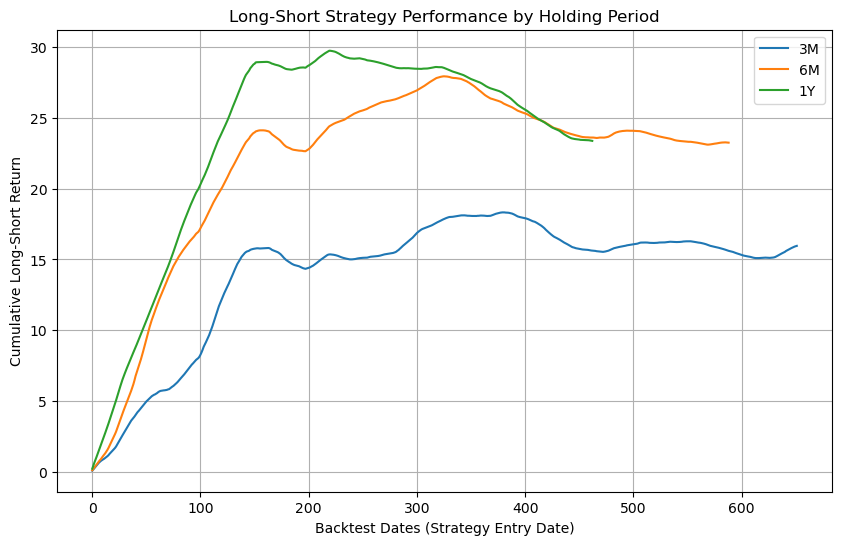

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
strategy_df["3M"].cumsum().plot(label="3M")
strategy_df["6M"].cumsum().plot(label="6M")
strategy_df["1Y"].cumsum().plot(label="1Y")
plt.xlabel("Backtest Dates (Strategy Entry Date)")
plt.ylabel("Cumulative Long-Short Return")
plt.title("Long-Short Strategy Performance by Holding Period")
plt.legend()
plt.grid(True)
plt.show()
